In [1]:
projPath_load='/home/alvaro/notebook/jupyterenv/bin/TFM/CODIGO/test_tfm_code_test/dfA_n2_zone_aturat_index_realatur_maniobras.csv'

In [2]:
projPath_save='/home/alvaro/notebook/jupyterenv/bin/TFM/CODIGO/test_tfm_code_test/'

In [3]:
month = '202206'
darsena = '_DM'

In [4]:
buffer_basin = 20 #m
buffer_dock = 30 #m
buffer_basin1 = 150 #m

min_points = 10

In [5]:
import numpy as np
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt

In [6]:
from shapely.geometry import Polygon, LineString

In [7]:
%matplotlib notebook

In [8]:
moll_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/MollsDarsenaMorrot_noTalo.shp')
dm_map = gpd.read_file('/home/alvaro/notebook/jupyterenv/bin/TFM/22-23_Maniobres-20221022T161922Z-001/22-23_Maniobres/data/maps/DarsenaMorrot.shp')

In [9]:
dm_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
dm_buffer = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin).to_crs(4326))
dm_buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
dm_buffer_z2 = gpd.GeoDataFrame(geometry = dm_map.to_crs(32631).buffer(buffer_basin1).to_crs(4326))
dm_buffer_z2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
moll_buffer = gpd.GeoDataFrame(geometry = moll_map.to_crs(32631).buffer(buffer_dock, cap_style = 2,join_style = 2).to_crs(4326))

<IPython.core.display.Javascript object>


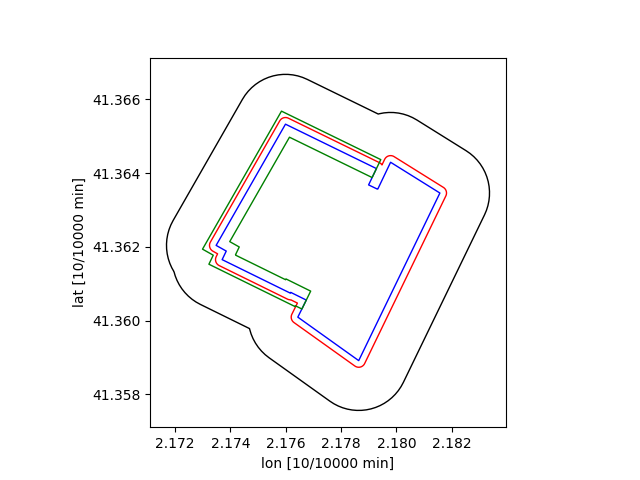

In [13]:
fig, ax = plt.subplots()
dm_map.plot(ax = ax, fc = 'none', ec = 'blue')
dm_buffer.plot(ax = ax, fc = 'none', ec = 'red')
moll_buffer.plot(ax = ax, fc = 'none', ec = 'green')
dm_buffer_z2.plot(ax = ax, fc = 'none', ec = 'black')

plt.xlabel('lon [10/10000 min]')
plt.ylabel('lat [10/10000 min]')
plt.show()

# Load Data

In [16]:
dfA_n2=pd.read_csv(projPath_load)

In [17]:
len(dfA_n2)

57339

GEO DATA

In [18]:
gdfA_n2 = gpd.GeoDataFrame(dfA_n2[['mmsi','lon','lat', 'shiptype']], geometry = gpd.points_from_xy(dfA_n2.lon, dfA_n2.lat),crs = dm_map.crs)

In [19]:
len(gdfA_n2)

57339

In [20]:
gdfA_n2

,mmsi,lon,lat,shiptype,geometry
0,247383500,2.17667,41.35834,74,POINT (2.17667 41.35834)
1,247383500,2.17678,41.35849,74,POINT (2.17678 41.35849)
2,247383500,2.17686,41.35864,74,POINT (2.17686 41.35864)
3,247383500,2.17695,41.35878,74,POINT (2.17695 41.35878)
4,247383500,2.17704,41.35892,74,POINT (2.17704 41.35892)
...,...,...,...,...,...
57334,247243600,2.17676,41.35868,60,POINT (2.17676 41.35868)
57335,247243600,2.17675,41.35865,60,POINT (2.17675 41.35865)
57336,247243600,2.17672,41.35860,60,POINT (2.17672 41.35860)
57337,247243600,2.17664,41.35848,60,POINT (2.17664 41.35848)


# New tables Creation

In [21]:
dfnt = pd.DataFrame(columns=['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi'])

In [36]:
gdfnt = gpd.GeoDataFrame(columns=['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi', 'geometria'])

In [23]:
adfnt = pd.DataFrame(columns=['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi', 'lat', 'lon'])

# Function definition

In [35]:
def geo_nova_taula (df):
    global gdfnt
    sub = df.copy()
    r1 = gdfA_n2.loc[sub.loc[sub['in_out']==1].index, 'geometry']
    lista1 = list(r1)
    poligono1 = LineString(lista1)
    r2 = gdfA_n2.loc[sub.loc[sub['in_out']==3].index, 'geometry']
    lista2 = list(r2)
    poligono2 = LineString(lista2)
    new_row = {'mmsi':sub.iloc[0]['mmsi'], 'index_maniobra':sub.iloc[0]['maniobras'], 'tipus':'ent', 'inici':sub.loc[sub['in_out']==1].index[0], 'fi': sub.loc[sub['in_out']==1].index[-1], 'geometria': poligono1  }
    new_row1 = {'mmsi':sub.iloc[0]['mmsi'], 'index_maniobra':sub.iloc[0]['maniobras'], 'tipus':'sort', 'inici':sub.loc[sub['in_out']==3].index[0], 'fi': sub.loc[sub['in_out']==3].index[-1], 'geometria': poligono2  }
    gdfnt = gdfnt.append(new_row, ignore_index=True)
    gdfnt = gdfnt.append(new_row1, ignore_index=True)

In [25]:
def nova_taula (dft):
    global dfnt
    dtt1 = dft.copy()
    new_row = {'mmsi':dtt1.iloc[0]['mmsi'], 'index_maniobra':dtt1.iloc[0]['maniobras'], 'tipus':'ent', 'inici':dtt1.loc[dtt1['in_out']==1].index[0], 'fi': dtt1.loc[dtt1['in_out']==1].index[-1]  }
    new_row1 = {'mmsi':dtt1.iloc[0]['mmsi'], 'index_maniobra':dtt1.iloc[0]['maniobras'], 'tipus':'sort', 'inici':dtt1.loc[dtt1['in_out']==3].index[0], 'fi': dtt1.loc[dtt1['in_out']==3].index[-1]  }
    dfnt = dfnt.append(new_row, ignore_index=True)
    dfnt = dfnt.append(new_row1, ignore_index=True)

In [26]:
def parat_nova_taula (df):
    global adfnt
    sub = df.copy()
    new_row = {'mmsi':sub.iloc[0]['mmsi'], 'index_maniobra':sub.iloc[0]['maniobras'], 'tipus':'parat', 'inici':sub.loc[sub['in_out']==2].index[0], 'fi': sub.loc[sub['in_out']==2].index[-1], 'lat':sub.loc[sub['in_out']==2,'lat'].mean(), 'lon':sub.loc[sub['in_out']==2,'lon'].mean()  }
    adfnt = adfnt.append(new_row, ignore_index=True)

# Group by and launch function

In [27]:
dft1 = dfA_n2.groupby(['mmsi', 'maniobras'])

In [28]:
dft1.apply(nova_taula)

""


In [37]:
dft1.apply(geo_nova_taula)

""


In [30]:
dft1.apply(parat_nova_taula)

""


In [31]:
(len(dfnt), len(gdfnt), len(adfnt))

(140, 140, 70)

In [32]:
dfnt

,mmsi,index_maniobra,tipus,inici,fi
0,209115000,0,ent,9927,10073
1,209115000,0,sort,10929,10953
2,209115000,1,ent,30445,30598
3,209115000,1,sort,30729,30753
4,209115000,2,ent,31276,31429
...,...,...,...,...,...
135,247383600,6,sort,39482,39561
136,247383600,7,ent,44270,44550
137,247383600,7,sort,44655,44770
138,247383600,8,ent,47000,47216


In [38]:
gdfnt

,mmsi,index_maniobra,tipus,inici,fi,geometria
0,209115000,0,ent,9927,10073,"LINESTRING (2.17694 41.35826, 2.17712 41.35854..."
1,209115000,0,sort,10929,10953,"LINESTRING (2.17761 41.3644, 2.17757 41.36359,..."
2,209115000,1,ent,30445,30598,"LINESTRING (2.17687 41.3584, 2.177 41.35864, 2..."
3,209115000,1,sort,30729,30753,"LINESTRING (2.17763 41.36439, 2.1778 41.36322,..."
4,209115000,2,ent,31276,31429,"LINESTRING (2.17676 41.35842, 2.17689 41.35864..."
...,...,...,...,...,...,...
135,247383600,6,sort,39482,39561,"LINESTRING (2.17736 41.36474000000001, 2.17748..."
136,247383600,7,ent,44270,44550,"LINESTRING (2.17674 41.35844, 2.17687 41.35862..."
137,247383600,7,sort,44655,44770,"LINESTRING (2.17738 41.36475, 2.17739 41.36474..."
138,247383600,8,ent,47000,47216,"LINESTRING (2.17647 41.35857, 2.17661 41.35877..."


In [31]:
adfnt

,mmsi,index_maniobra,tipus,inici,fi,lat,lon
0,209115000,0,parat,10074,10928,41.364478,2.177592
1,209115000,1,parat,30599,30728,41.364475,2.177594
2,209115000,2,parat,31430,31589,41.364474,2.177589
3,210117000,0,parat,40228,40266,41.364162,2.178765
4,247219400,0,parat,1273,2420,41.363832,2.175074
...,...,...,...,...,...,...,...
65,247383600,4,parat,31816,31902,41.364774,2.177328
66,247383600,5,parat,37382,37521,41.364774,2.177332
67,247383600,6,parat,39428,39481,41.364774,2.177332
68,247383600,7,parat,44551,44654,41.364780,2.177327


# SAVE DATA

In [32]:
dfnt.to_csv(projPath_save +'TAULA_DEF.csv', index = False, columns = ['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi'])

In [33]:
gdfnt.to_csv(projPath_save +'GEO_TAULA_DEF.csv', index = False, columns = ['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi', 'geometria'])

In [34]:
adfnt.to_csv(projPath_save +'ATURAT_TAULA_DEF.csv', index = False, columns = ['mmsi', 'index_maniobra', 'tipus', 'inici', 'fi', 'lat', 'lon'])